### NPZD model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

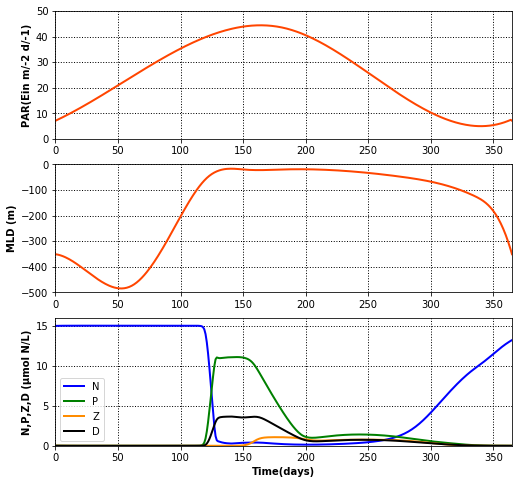

In [2]:
#NPZD Model
#Interactions amomg nutrient availability,phytoplankton growth,
#phytoplankton stock size and zooplankton stock size

M = np.loadtxt("mld.dat") # mixed layer depth (M)
Io = np.loadtxt("par.dat") # irradiance at z=0 (Io)
T = np.loadtxt("sst.dat") # sea surface temperature (T)

M = M[1,:]
Io = Io[1,:]
T = T[1,:]

ldiff = M[365] - M[364]
dt = 1.0      # 1.0 is the time interval (1 day )
h = np.ediff1d(M, to_end=ldiff)/dt  # calculates rate of change of M

#Initial Conditions
N0 = 15.0
P0 = 0.01
Z0 = 0.01
D0 = 0.01

#Parameters
N_zero = 15.0
Pmax = 1.1
gmax = 0.9
KN = 0.85
KZ = 0.6
mP = 0.2
mZ = 0.1
mD = 0.6
Beta = 0.69
KNZ = 0.75
Kw = 0.05
Kp = 0.03
Alpha = 0.15
k_petit = 0.1
mz_asterik = 0.34
PhiP = 0.67
PhiD = 0.33

#Create functions for NPZD process

#Temperature dependence according to the Eppley’s formulation
def temp(t):
    f = np.exp(0.063*T[t])
    return f

#Nutrient limitation
def uptake(N):
    u = N/(N+KN)
    return u

#Light limitation function
def light(t,P):
    I_M = Io[t] * np.exp(-(Kw+Kp*P)**M[t])
    l = Pmax/((Kw+Kp*P)*M[t]) * np.log(Alpha * Io[t] + np.sqrt(Pmax**2+(Alpha*Io[t])**2) / (Alpha * I_M + np.sqrt(Pmax**2+(Alpha*I_M)**2)))
    return l

#Mixing function
def mix(t):
    h_plus = max(h[t],0)
    K =(k_petit + h_plus)/M[t]
    return K

#Grazing functions
#function 7
def grazeP(P,D):
    g = (gmax*PhiP*(P**2)/(KZ**2+ PhiP*(P**2) + PhiD*(D**2)))
    return g

#function 8
def grazeD(P,D):
    s = (gmax*PhiD*(D**2)/(KZ**2+ PhiP*(P**2) + PhiD*(D**2)))
    return s


#Initial Condition
y0 = [15.0, 0.01, 0.01, 0.01]

#Defining the differential equations for NPZD model
def NPZD(y,t):
    N, P, Z, D = y
    t = int(t)

    dNdt = (-temp(t) * uptake(N) * light(t,P)) * P + mD * D + Beta*(1-KNZ)*(grazeP(P,D) + grazeD(P,D))*Z + mix(t)*(N_zero - N) 
    dPdt = (temp(t) * uptake(N) * light(t,P)) * P - mP * P - grazeP(P,D) * Z - mix(t) * P
    dZdt = Beta * KNZ*(grazeP(P,D) + grazeD(P,D))*Z - mZ * Z - mz_asterik * Z**2 - (h[t]/M[t]) * Z
    dDdt = mP * P + mZ * Z + (1 - Beta)*(grazeP(P,D) + grazeD(P,D))*Z - grazeD(P,D) * Z - mD * D - mix(t) * D
    dydt = [dNdt, dPdt, dZdt, dDdt]
    return dydt


t = np.arange(366)

sol = odeint(NPZD, y0, t)

#Plotting
#Stable solutions plotted along with forcing variables("par" and "mld")
fig1 = plt.figure(figsize=(18,8))

plt.subplot(321)
plt.plot(t,Io, 'orangered', linewidth=2)
plt.ylabel('PAR(Ein m/-2 d/-1)', fontweight="bold" )

plt.xlim(0,365)
plt.ylim(0,50)
plt.grid(color='k', linestyle='dotted', linewidth=1)

plt.subplot(323)
plt.plot(t,-M, 'orangered', linewidth=2)
plt.ylabel('MLD (m)', fontweight = "bold")
plt.xlim(0,365)
plt.ylim(-500,0)
plt.grid(color='k', linestyle='dotted', linewidth=1)


plt.subplot(325)
plt.plot(t,sol[:,0],'b', linewidth=2, label='N')
plt.plot(t,sol[:,1],'g', linewidth=2, label='P')
plt.plot(t,sol[:,2],'darkorange', linewidth=2, label='Z')
plt.plot(t,sol[:,3],'k', linewidth=2, label='D')
plt.xlim(0,365)
plt.ylim(0,16)
plt.xlabel('Time(days)', fontweight = "bold")
plt.ylabel('N,P,Z,D (μmol N/L)', fontweight = "bold")   
plt.grid(color='k', linestyle='dotted', linewidth=1)

plt.legend()

plt.show()

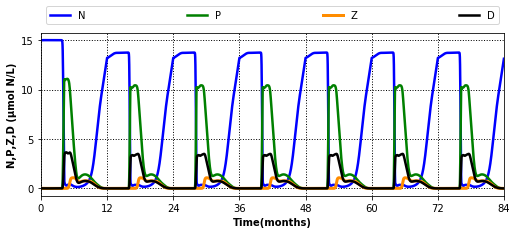

In [3]:
#Running the model over several years with the same environmental variables
yrs = 7

M = np.tile(M[0:365],yrs)
Io = np.tile(Io[0:365],yrs)
T = np.tile(T[0:365],yrs)
h = np.tile(h[0:365],yrs)

t = np.arange(0,365*yrs,1)

sol = odeint(NPZD, y0, t)


#Plotting 
fig2 = plt.figure(figsize=(8.3,3))

plt.plot(t/365*12,sol[:,0],'b', linewidth=2.5,label='N')
plt.plot(t/365*12,sol[:,1],'g', linewidth=2.5, label='P')
plt.plot(t/365*12,sol[:,2],'darkorange', linewidth=3, label='Z')
plt.plot(t/365*12,sol[:,3],'k', linewidth=2.5, label='D')
plt.xticks(np.arange(0, 85, step=12))
plt.yticks(np.arange(0, 16, step=5))
plt.xlim(0,12*yrs)
plt.xlabel('Time(months)', fontweight = "bold")
plt.ylabel('N,P,Z,D (μmol N/L)', fontweight = "bold")
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", 
           mode="expand",ncol=4)

plt.grid(color='k', linestyle='dotted', linewidth=1)


plt.show()
